In [26]:
import torch
from torch import nn
from pandas import DataFrame
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

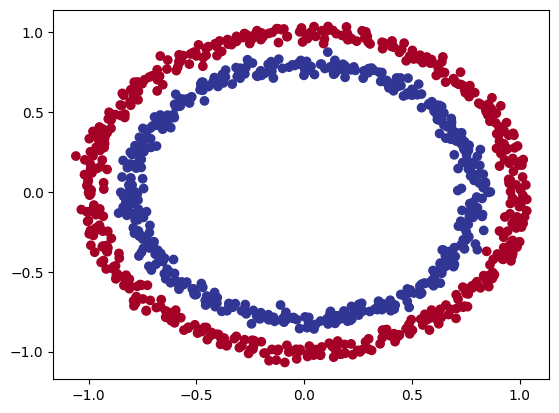

In [27]:
import torch
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Make and plot data
n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

# Split using NumPy arrays
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors and move to CUDA
X_train = torch.from_numpy(X_train_np).float().to("cuda")
X_test = torch.from_numpy(X_test_np).float().to("cuda")
y_train = torch.from_numpy(y_train_np).float().to("cuda")
y_test = torch.from_numpy(y_test_np).float().to("cuda")

In [28]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        # non linear activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # where should we put our non linear activation function
        # x -> layer_1 -> relu -> layer_2 -> relu -> layer_3
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device="cuda")

model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2624,  0.6641],
                      [-0.0997, -0.0055],
                      [-0.1628, -0.5904],
                      [ 0.3393, -0.7020],
                      [ 0.4390,  0.5291],
                      [ 0.6687, -0.1668],
                      [-0.5810,  0.1590],
                      [ 0.3906, -0.7038],
                      [-0.1605, -0.4239],
                      [-0.0618, -0.3480]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2890, -0.2245, -0.6720,  0.5802,  0.5928, -0.1109, -0.0805, -0.2886,
                      -0.6386, -0.6881], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1175, -0.1736, -0.2033, -0.0247, -0.1053, -0.1023,  0.0102, -0.0671,
                       -0.1089, -0.1514],
                      [-0.2574,  0.2652, -0.1266,  0.0838, -0.1097,  0.0257,  0.2948,  0.1457,
                       -0.2740,  0.1255],
                      [ 0.3002,  0.083

In [29]:
loss_fn = nn.BCEWithLogitsLoss()

optimzer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)



In [30]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [32]:
epochs = 2000

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)
    
    optimzer.zero_grad()
    
    loss.backward()
    
    optimzer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_loss = loss_fn(y_test, test_logits)
        test_logits_preds = torch.round(torch.sigmoid(test_logits))
        test_preds = accuracy_fn(y_true=y_test, y_pred=test_logits_preds)
        
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss:.5f} | Test loss: {test_loss:.5f} | Train acc: {acc:.2f}% | Test acc: {test_preds:.2f}%")

Epoch: 0 | Train loss: 0.69896 | Test loss: 0.86926 | Train acc: 50.00% | Test acc: 50.00%
Epoch: 10 | Train loss: 0.69419 | Test loss: 0.90617 | Train acc: 50.00% | Test acc: 50.00%
Epoch: 20 | Train loss: 0.69148 | Test loss: 0.93305 | Train acc: 50.00% | Test acc: 50.00%
Epoch: 30 | Train loss: 0.68991 | Test loss: 0.95228 | Train acc: 55.62% | Test acc: 53.50%
Epoch: 40 | Train loss: 0.68851 | Test loss: 0.96591 | Train acc: 58.38% | Test acc: 55.00%
Epoch: 50 | Train loss: 0.68720 | Test loss: 0.97597 | Train acc: 54.87% | Test acc: 52.00%
Epoch: 60 | Train loss: 0.68661 | Test loss: 0.98242 | Train acc: 57.75% | Test acc: 53.00%
Epoch: 70 | Train loss: 0.68617 | Test loss: 0.98652 | Train acc: 61.25% | Test acc: 58.50%
Epoch: 80 | Train loss: 0.68576 | Test loss: 0.98926 | Train acc: 61.38% | Test acc: 57.00%
Epoch: 90 | Train loss: 0.68537 | Test loss: 0.99123 | Train acc: 60.50% | Test acc: 56.00%
Epoch: 100 | Train loss: 0.68499 | Test loss: 0.99253 | Train acc: 59.62% | Test 

In [33]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

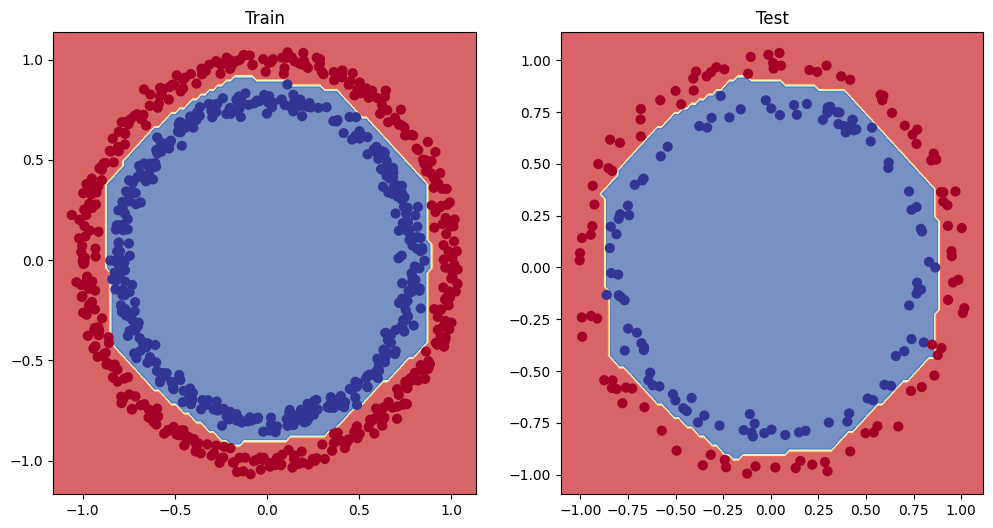

In [34]:
# Plot decision boundaries for training and test sets
from helper_functions import plot_decision_boundary


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)  # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)  # model_3 = has non-linearity



# replicating non linear activation functions 

In [35]:
# create a tensor 

A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

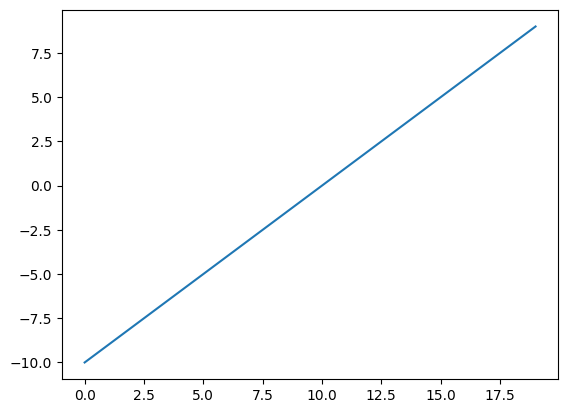

In [36]:
# visualizing the data 

plt.plot(A)

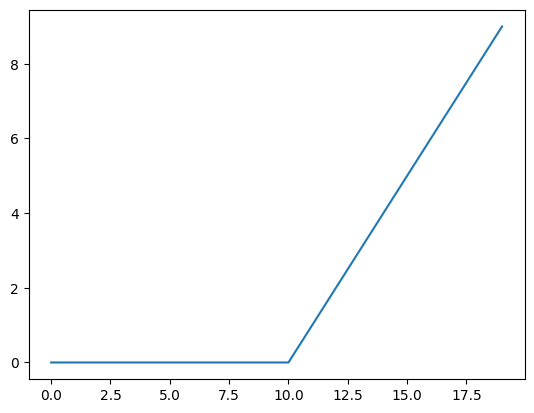

In [37]:
plt.plot(torch.relu(A))

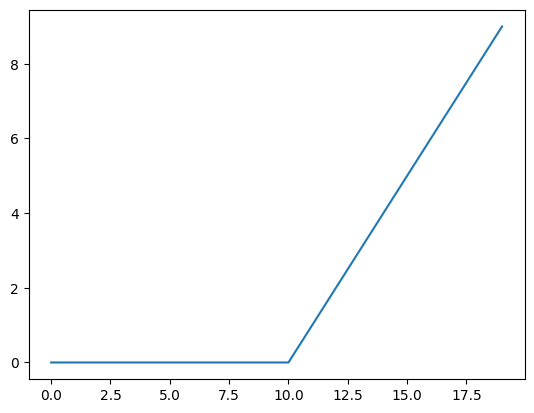

In [38]:
def relu(x: torch.Tensor):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors 


plt.plot(relu(A))

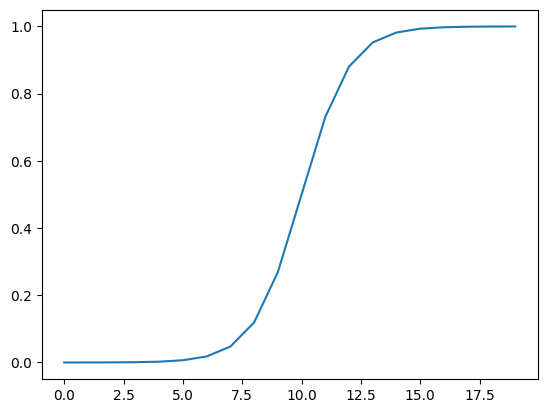

In [39]:
def sigmoid(x:torch.Tensor):
    return 1 / (1 + torch.exp(-x))
    
    
plt.plot(sigmoid(A))

# putting it all together with multi class classification problem

### creating a toy dataset

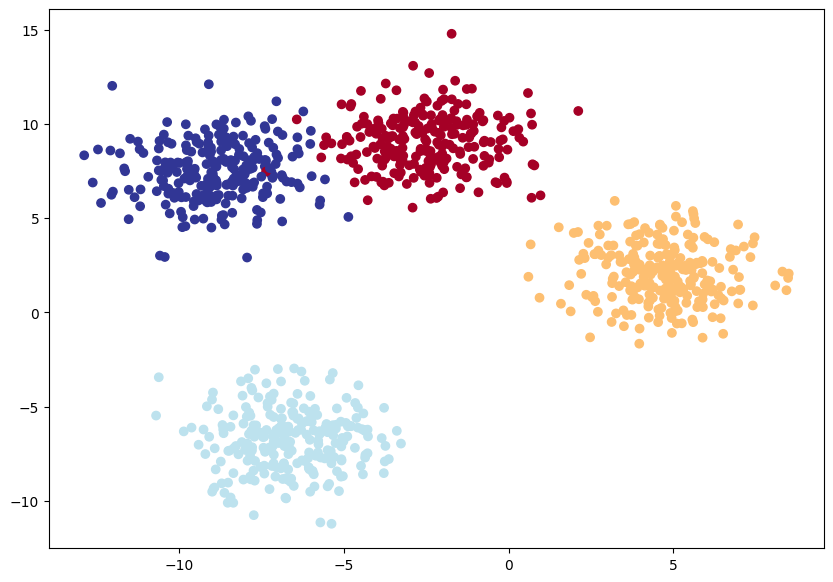

In [40]:
import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs 
from sklearn.model_selection import train_test_split
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# CREATE MULTI CLASS DATA 
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# turn data into tensors 
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.float32)

# split into train and test 
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state =RANDOM_SEED)

#  plot the data 

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)





## bulding a multiclass classification model

In [41]:
# creating device agnostic cide

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [42]:
X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)

In [43]:
# build a multi class classification model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        """
        initilizes multiclassification model
        """
        super().__init__()
        
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            nn.ReLU()
        )
    
    def forward(self, x:torch.Tensor):
        # pass the data through the layers
        return self.linear_layer_stack(x)
    


# create an instance of the model

# input_features = number of X features
# output_features = number of total classes

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)


model_4
        

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
  )
)

In [44]:
X_blob_train, y_blob_train

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         ...,
         [-1.7366,  9.7850],
         [-6.8139, -7.1006],
         [-9.0311,  4.5007]], device='cuda:0'),
 tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0., 0., 0., 3., 2., 3., 2., 1., 1.,
         3., 2., 2., 2., 3., 1., 3., 2., 3., 0., 1., 0., 0., 1., 1., 3., 0., 2.,
         2., 1., 1., 3., 1., 1., 2., 3., 3., 0., 0., 0., 1., 0., 0., 0., 2., 0.,
         1., 1., 0., 0., 2., 2., 3., 1., 0., 2., 1., 3., 2., 2., 2., 1., 0., 2.,
         3., 1., 1., 1., 2., 0., 0., 1., 2., 3., 1., 3., 3., 2., 3., 3., 2., 2.,
         1., 0., 0., 1., 2., 1., 3., 1., 2., 1., 3., 3., 3., 0., 2., 1., 2., 3.,
         1., 1., 2., 0., 3., 3., 2., 0., 2., 0., 3., 2., 0., 0., 2., 2., 0., 1.,
         2., 0., 3., 3., 2., 3., 2., 1., 3., 1., 1., 1., 1., 0., 0., 1., 0., 2.,
         3., 0., 0., 0., 0., 0., 1., 0., 3., 0., 0., 2., 2., 0., 0., 3., 0., 3.,
         3., 3., 0., 2., 0., 1., 2., 2., 2., 3., 0., 1., 1., 0.,

In [45]:
# create a loss function
loss_fn = torch.nn.CrossEntropyLoss()
# create an optimizer 
optimzer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [47]:
# getting prediction probs for a multi class model
model_4.eval()
with torch.inference_mode():
    predictions = model_4(X_blob_test).squeeze().to(device)
    pred_probs = torch.round(torch.sigmoid(predictions))
    
    print(pred_probs[:5], y_blob_test[:5])

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0') tensor([1., 3., 2., 1., 0.], device='cuda:0')
